In [1]:
import pandas as pd
import numpy as np
import random
import os
from IPython.display import clear_output
from google.cloud import bigquery # SQL table interface on Arcus
from dxFilterLibraryPreGrading import *
from reportMarkingFunctions import *
from projectTableFunctions import * 
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Initialize the client service
client = bigquery.Client()

req_table = "lab.test_requested_sessions_main_with_metadata"
grader_table = "lab.test_grader_table_with_metadata"

In [3]:
backup_grader_table()

lab.test_grader_table_with_metadata  backup successful


In [ ]:
## This is about testing the process for adding multiple cohorts to individuals
import json
import os

# check_table_for_cohort_includi
table_name = "lab.grader_table_with_metadata"
config_fn = "/home/youngjm/bgdlab/code/annotation-helper-tools/queries/config.json"

# THIS IS A FUNCTION
# Load the config file
with open(config_fn, "r") as f:
    dict_query = json.load(f)

# The following is only for running on the grader_table_with_metadata, it 
# is not suited for running during report queuing yet
for cohort in list(dict_query):
    print(cohort)
    # Load cohort config
    q_cohort = load_cohort_config(cohort)
    
    # Modify the query to get any patient in the specified table
    # who is identified with the query and the dx filter but not 
    # tagged with the cohort name 
    q_cohort_updated = "with CTE as ("+q_cohort.replace(';', ' ')+") select my_tab.* from "+table_name
    q_cohort_updated +=' my_tab join CTE on my_tab.proc_ord_id = CTE.proc_ord_id where project not like "%'+cohort
    q_cohort_updated +='%" and grader_name not like "%Coarse Text Search%"; '
    
    # Run the query to get the proc ord ids and their project names
    df = client.query(q_cohort_updated).to_dataframe()
    print(df.shape)
    
    # For each row in the dataframe
    for idx, row in df.iterrows():
        # Get the project column
        proj = row['project']
        projects = proj.replace("; ", ";").split(";")
        projects.append(cohort)
        # Create the updated string for the project column 
        # -- Do I want this sorted alphabetically by project name?
        updated_projects = "; ".join(sorted(projects))
        # Write the update query
        q_update_projects = 'update '+table_name+' set project="'+updated_projects
        q_update_projects += '" where pat_id="'+row['pat_id']+'" and proc_ord_id="'
        q_update_projects += row['proc_ord_id']+'" and grader_name="'+row['grader_name']+'" ;'
        job = client.query(q_update_projects)
        job.result()

print("Project Cohorts updated")




SLIP Neonates
(0, 11)
SLIP Toddlers
(0, 11)
SLIP PreK
(0, 11)
SLIP Elementary
(0, 11)
SLIP Adolescents
(1833, 11)


In [9]:
q = '''select
  pat_id,
  proc_ord_id,
  proc_ord_desc,
  proc_ord_age,
  proc_ord_year
from
  arcus.procedure_order
where
  proc_ord_desc like "MR FETAL%"
order by proc_ord_age'''

df = client.query(q).to_dataframe()
df['age_in_years'] = df['proc_ord_age'].astype(int)/365.25

plt.hist(df['age_in_years'], bins = 50)
plt.title("Histogram of Age At Scan")
plt.xlabel("Age at Scan (years)")
plt.ylabel("Count")
plt.grid(visible=True)

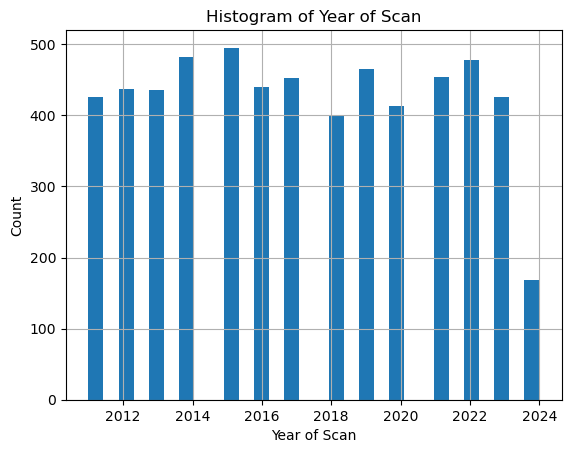

In [16]:
plt.hist(df['proc_ord_year'], bins = 30)
plt.title("Histogram of Year of Scan")
plt.xlabel("Year of Scan")
plt.ylabel("Count")
plt.grid(visible=True)

In [19]:
len(list(df['pat_id'].values))

5973

In [7]:
q = 'select pat_id, proc_ord_id, project from lab.grader_table_with_metadata where grade_date like "%2024%" ;'
df = client.query(q).to_dataframe()
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

projects = sorted(list(set("; ".join(list(set(df['project'].values))).split("; "))))
for project in projects:
    if project != 'SLIP':
        count = len(df[df['project'].str.contains(project)])
        print(project, count)

(15438, 3)
(8810, 3)
Clinical Fetal 100
Clinical Imaging Genetics 407
Indication Psychosis 146
Pb Cohort 683
SLIP Adolescents 5451
SLIP Elementary 2133
SLIP PreK 220
SLIP Toddlers 100


In [19]:
## And now for something completely different: going to make a separate lab.proc_ord_project table
drop_table = "DROP TABLE lab.proc_ord_projects"
job = client.query(drop_table)
job.result()
create_table = "CREATE TABLE lab.proc_ord_projects (proc_ord_id STRING, pat_id STRING, project STRING)"
job = client.query(create_table)
job.result()

# Read the config file
cfg_fn = "./queries/config.json"
with open(cfg_fn, 'r') as f:
    cfg = json.load(f)
for cohort in cfg:
    # Load the query for the cohort
    print(cohort)
    project_query = load_cohort_config(cohort)
    # Get the pat/proc combos for the project
    df = client.query(project_query).to_dataframe()[['proc_ord_id', 'pat_id']]
    df = df.drop_duplicates()
    # Add the pat/proc combos to the proc_ord_projects table
    count = 0
    add_projects_query = 'insert into lab.proc_ord_projects (proc_ord_id, pat_id, project) VALUES '
    for idx, row in df.iterrows():
        if count < 100:
            add_projects_query += '("'+str(row['proc_ord_id'])+'", "'+str(row['pat_id'])+'", "'+cohort+'"), '
            count += 1
        else:
            add_projects_query = add_projects_query[:-2]+";"
            job = client.query(add_projects_query)
            job.result()
            add_projects_query = 'insert into lab.proc_ord_projects (proc_ord_id, pat_id, project) VALUES '
            count = 0
    add_projects_query = add_projects_query[:-2]+";"
    job = client.query(add_projects_query)
    job.result()


SLIP Neonates
SLIP Toddlers
SLIP PreK
SLIP Elementary
SLIP Adolescents
Clinical Imaging Genetics
VIP Clinical Imaging Genetics
Pb Cohort
Clinical Fetal
Indication Psychosis
22q11


In [23]:
# Next test: how many rows are in our new project table? how many unique pat_ids? for a cohort, are there any duplicate rows?

# 1. How many rows are in our new project table
q_rows = "select proc_ord_id, pat_id, project from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

# 2. How many unique patients are in the table?
q_rows = "select distinct pat_id from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

# 3. How many unique rows are in the table?
q_rows = "select distinct proc_ord_id, pat_id, project from lab.proc_ord_projects"
df = client.query(q_rows).to_dataframe()
print(df.shape)

(77697, 3)
(53184, 1)
(77697, 3)


In [4]:
# Next step: make copies of existing tables without the project columns.
q_drop = "drop table lab.test_grader_table_with_metadata"
job = client.query(q_drop)

# grader table
q_make_and_modify = "create table lab.test_grader_table_with_metadata as "
q_make_and_modify += "(select proc_ord_id, grader_name, grade, grade_category, "
q_make_and_modify += "pat_id, age_in_days, proc_ord_year, proc_name, "
q_make_and_modify += "report_origin_table, grade_date from lab.grader_table_with_metadata)"
job = client.query(q_make_and_modify)
job.result()

q_test = "select * from lab.test_grader_table_with_metadata"
df = client.query(q_test).to_dataframe()
print(df.shape)
print(df.drop_duplicates().shape)

# request table
q_drop = "drop table lab.test_requested_sessions_main_with_metadata"
job = client.query(q_drop)

# No more modifications to this table as of 2024-10-21
# q_make_and_modify = "create table lab.test_requested_sessions_main_with_metadata as "
# q_make_and_modify += "(select pat_id, proc_ord_id, proc_ord_age, proc_ord_year, "
# q_make_and_modify += "proc_ord_desc, report_origin_table, grade_category, avg_grade, "
# q_make_and_modify += "sex, race, ethnicity, dob_year, gestational_age_num, "
# q_make_and_modify += "birth_weight_kg, birth_length_cm, request_label "
# q_make_and_modify += "from lab.requested_sessions_main_with_metadata)"
# job = client.query(q_make_and_modify)
# job.result()

# q_test = "select * from lab.test_requested_sessions_main_with_metadata"
# df = client.query(q_test).to_dataframe()
# print(df.shape)
# print(df.drop_duplicates().shape)

(225633, 10)
(225063, 10)
(17897, 16)
(17896, 16)


In [15]:
# Load the config
cfg = "./queries/config.json"
with open(cfg, "r") as f:
    cohort_lookup = json.load(f)

cohort_list = list(cohort_lookup.keys())
print(cohort_list)

# for cohort in cohort_list:
#     print(cohort)
#     add_reports_to_project(cohort)

['SLIP Neonates', 'SLIP Toddlers', 'SLIP PreK', 'SLIP Elementary', 'SLIP Adolescents', 'Clinical Imaging Genetics', 'VIP Clinical Imaging Genetics', 'Pb Cohort', 'Clinical Fetal', 'Indication Psychosis', '22q11']


In [3]:
for cohort in cohort_list:
    print()
    get_project_report_stats(cohort)


Project: SLIP Neonates
Total reports: 2003 (note each report must be graded by 2 graders)
Graded 0: 5
Graded 1: 9
Graded 2: 7
Queued: 0
Skipped: 0

Project: SLIP Toddlers
Total reports: 7195 (note each report must be graded by 2 graders)
Graded 0: 90
Graded 1: 37
Graded 2: 135
Queued: 20
Skipped: 2

Project: SLIP PreK
Total reports: 5763 (note each report must be graded by 2 graders)
Graded 0: 76
Graded 1: 178
Graded 2: 304
Queued: 10
Skipped: 2

Project: SLIP Elementary
Total reports: 15009 (note each report must be graded by 2 graders)
Graded 0: 806
Graded 1: 2104
Graded 2: 914
Queued: 289
Skipped: 12

Project: SLIP Adolescents
Total reports: 16484 (note each report must be graded by 2 graders)
Graded 0: 1469
Graded 1: 1875
Graded 2: 2976
Queued: 80
Skipped: 3

Project: Clinical Imaging Genetics
Total reports: 7077 (note each report must be graded by 2 graders)
Graded 0: 3690
Graded 1: 107
Graded 2: 121
Queued: 11
Skipped: 0

Project: VIP Clinical Imaging Genetics
Total reports: 453

In [2]:
# Building functions to summarize data set status
cohort = "SLIP Toddlers"

# 1. How many reports exist and have been graded?
get_project_report_stats(cohort)

Project: SLIP Toddlers
Total reports: 7195 (note each report must be graded by 2 graders)
Graded 0: 96
Graded 1: 45
Graded 2: 150
Queued: 1
Skipped: 3


['proc_ord_id', 'grader_name', 'grade', 'grade_category', 'pat_id', 'age_in_days', 'proc_ord_year', 'proc_name', 'report_origin_table', 'grade_date', 'sex']


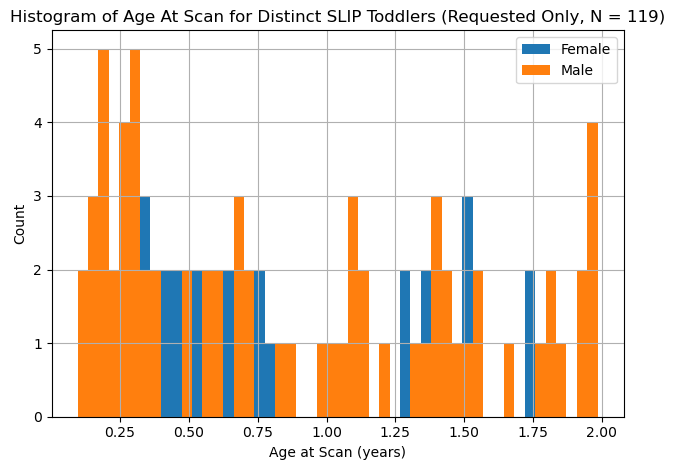

In [14]:
# 2. What is the distribution of age at scan for 
# 2a. [x] for all cohort reports 
# 2b. [x] for requested reports
# 2c. [x] split by grade 
# 2d. [x] split by sex

plot_age_at_scan(cohort, color_by=['sex'], only_requested=True)

# 3. When did the scans occur?

In [ ]:
df_cohort = get_unique_report_data(cohort, only_requested=False)
df_cohort.head(10)


fig, ax = plt.subplots(1, 1, tight_layout=True)


grades = list(set(df_cohort['avg_grade_group'].values))
_, bin_edges = np.histogram(df_cohort['age_in_years'], 50)
for grade in sorted(grades):
    ax.hist(df_cohort[df_cohort['avg_grade_group'] == grade]['age_in_years'], 
                      bin_edges, histtype='bar', 
                      stacked=True, label=str(grade))


plt.xlabel("Age at Scan (years)")
plt.ylabel("Count")
plt.legend()
plt.grid(visible=True)
plt.show()


1000
3


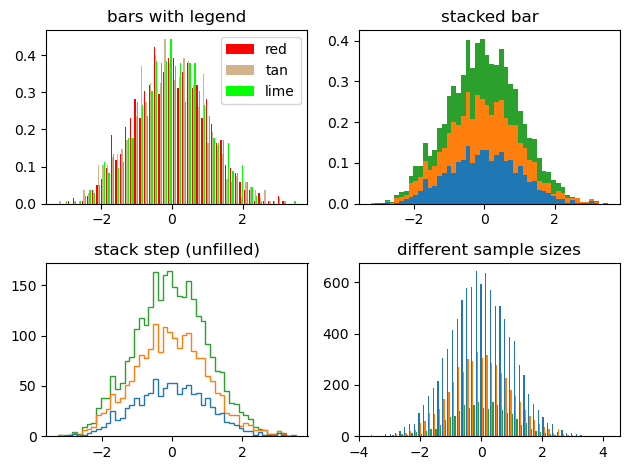

In [81]:
n_bins = 50
x = np.random.randn(1000, 3)
print(len(x))
print(len(x[0]))


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors_str = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors_str, label=colors_str)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()
